In [1]:
import time
import numpy as np
import ROOT

canvas = ROOT.TCanvas()

Welcome to JupyROOT 6.24/00


In [2]:
rootfile = ROOT.TFile.Open("data/HiggsZZ4mu.root")
roottree = rootfile.Get("Events")

In [3]:
starttime = time.time()

roothist = ROOT.TH1D("roothist", "mass", 120, 0, 120)

for index, event in enumerate(roottree):
    # Applying cuts means if-statements.
    if event.nMuon >= 2 and event.Muon_charge[0] + event.Muon_charge[1] == 0:
        mu1_pt = event.Muon_pt[0]
        mu2_pt = event.Muon_pt[1]
        mu1_eta = event.Muon_eta[0]
        mu2_eta = event.Muon_eta[1]
        mu1_phi = event.Muon_phi[0]
        mu2_phi = event.Muon_phi[1]
        roothist.Fill(
            np.sqrt(2*mu1_pt*mu2_pt*(np.cosh(mu1_eta - mu2_eta) - np.cos(mu1_phi - mu2_phi)))
        )

pyroot_time = time.time() - starttime
print(f"total time: {pyroot_time} sec")

total time: 19.430471420288086 sec


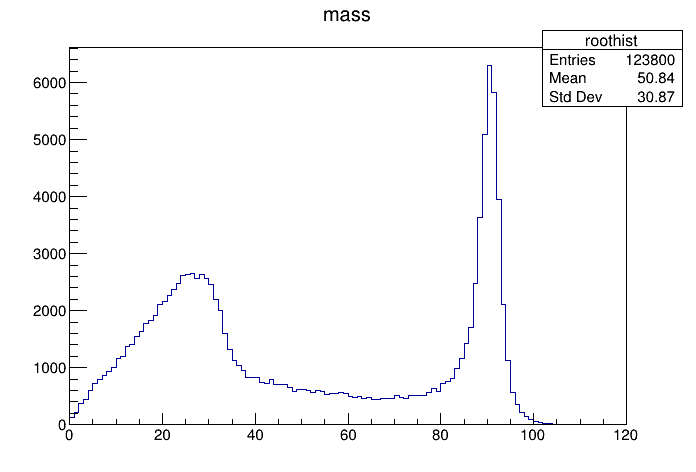

In [4]:
roothist.Draw()
canvas.Draw()

In [5]:
ROOT.gInterpreter.Declare('''
void compute(TH1D& roothist, TTree& roottree) {
    UInt_t nMuon;
    float Muon_pt[50];
    float Muon_eta[50];
    float Muon_phi[50];
    int32_t Muon_charge[50];

    roottree.SetBranchStatus("*", 0);
    roottree.SetBranchStatus("nMuon", 1);
    roottree.SetBranchStatus("Muon_pt", 1);
    roottree.SetBranchStatus("Muon_eta", 1);
    roottree.SetBranchStatus("Muon_phi", 1);
    roottree.SetBranchStatus("Muon_charge", 1);

    roottree.SetBranchAddress("nMuon", &nMuon);
    roottree.SetBranchAddress("Muon_pt", Muon_pt);
    roottree.SetBranchAddress("Muon_eta", Muon_eta);
    roottree.SetBranchAddress("Muon_phi", Muon_phi);
    roottree.SetBranchAddress("Muon_charge", Muon_charge);

    for (int index = 0; index < 100000; index++) {
        roottree.GetEntry(index);
        if (nMuon >= 2 && Muon_charge[0] + Muon_charge[1] == 0) {
            float mu1_pt = Muon_pt[0];
            float mu2_pt = Muon_pt[1];
            float mu1_eta = Muon_eta[0];
            float mu2_eta = Muon_eta[1];
            float mu1_phi = Muon_phi[0];
            float mu2_phi = Muon_phi[1];
            roothist.Fill(
                sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)))
            );
        }
    }
}
''')

True

In [6]:
starttime = time.time()

roothist2 = ROOT.TH1D("roothist2", "mass", 120, 0, 120)

ROOT.compute(roothist2, roottree)

cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")

total time: 0.035958290100097656 sec


In [7]:
pyroot_time / cpproot_time

540.361384431773

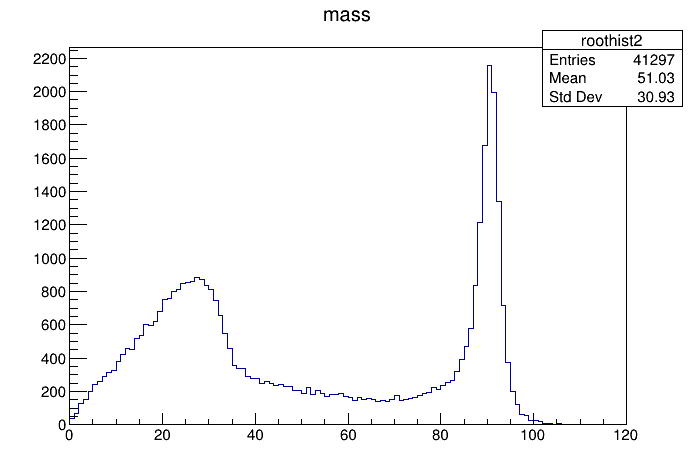

In [8]:
roothist2.Draw()
canvas.Draw()

<img src="img/rdataframe-flow.svg" style="width: 800px">

In [9]:
df = ROOT.RDataFrame("Events", "data/HiggsZZ4mu.root")

# Each node is connected to the previous, in a chain (which can split and recombine).
df_2mu = df.Filter("nMuon >= 2")
df_os = df_2mu.Filter("Muon_charge[0] + Muon_charge[1] == 0")

# This node is a big C++ block.
df_mass = df_os.Define("Dimuon_mass", '''
float mu1_pt = Muon_pt[0];
float mu2_pt = Muon_pt[1];
float mu1_eta = Muon_eta[0];
float mu2_eta = Muon_eta[1];
float mu1_phi = Muon_phi[0];
float mu2_phi = Muon_phi[1];
return sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)));
''')

In [10]:
starttime = time.time()

# This one is an endpoint (action).
roothist3 = df_mass.Histo1D(("h3", "mass", 120, 0, 120), "Dimuon_mass")

rdfroot_time = time.time() - starttime
print(f"total time: {rdfroot_time} sec")

total time: 0.09838652610778809 sec


In [11]:
pyroot_time / rdfroot_time

197.4911828780385

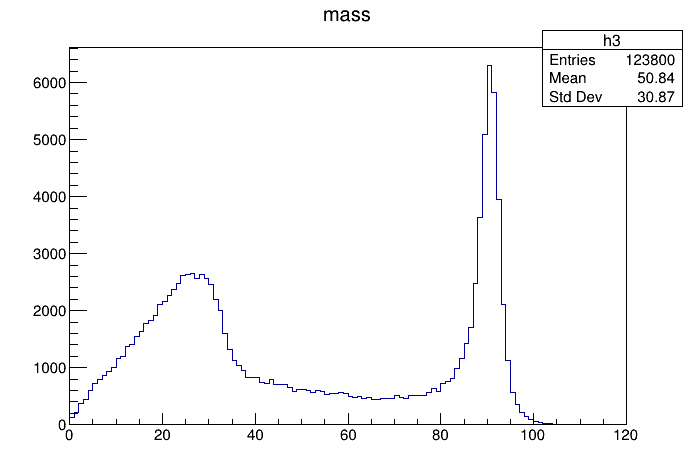

In [12]:
roothist3.Draw()
canvas.Draw()

In [13]:
import awkward as ak
import uproot
import hist

In [14]:
events = uproot.open("data/HiggsZZ4mu.root:Events")
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))
MET_pt               | float                    | AsDtype('>f4')
MET_phi              | float                    | AsDtype('>f4')
nGenPart             | uint32_t                 | AsDtype('>u4')
GenPart_

In [15]:
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"}
)
muons

<Array [{pt: [], eta: [], ... -1, 1, -1]}] type='299683 * {"pt": var * float32, ...'>

In [16]:
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
cut

<Array [False, True, False, ... True, True] type='299683 * bool'>

In [17]:
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
mu1, mu2

(<Array [{pt: 18.6, eta: -0.179, ... charge: 1}] type='123800 * {"pt": float32, "...'>,
 <Array [{pt: 23.6, eta: 0.224, ... charge: -1}] type='123800 * {"pt": float32, "...'>)

In [18]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double())

In [19]:
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 123753.0 (123800.0 with flow)

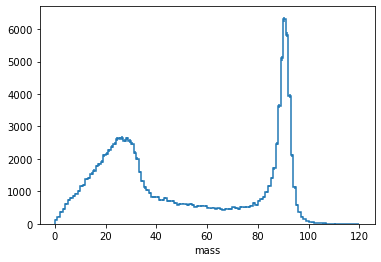

In [20]:
import matplotlib.pyplot as plt

h.plot();

In [21]:
starttime = time.time()

# read data
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},
    array_cache=None,   # no cheating!
)

# compute
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

uproot_time = time.time() - starttime
print(f"total time: {uproot_time} sec")

total time: 0.07655501365661621 sec


In [22]:
pyroot_time / uproot_time

253.81056696616267

<img src="img/terminology.svg" style="width: 800px">

In [23]:
histograms = uproot.open("data/HiggsZZ4mu_histograms.root")

In [ ]:
histograms.keys()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe4e1a73a60>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

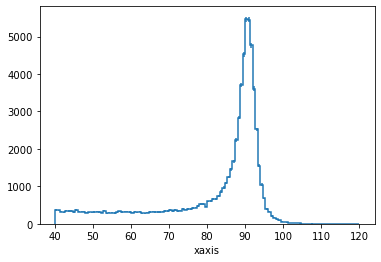

In [24]:
histograms["Z/all/massZto2muon"].to_hist().plot()

In [ ]:
# find the 2D histogram and plot it

In [ ]:
icecube = uproot.open("data/icecube-supernovae.root")
icecube.keys()

In [ ]:
icecube.classname_of("config/detector")

In [ ]:
icecube.file.show_streamers("I3Eval_t")

In [ ]:
icecube["config/detector"]

In [ ]:
icecube["config/detector"].all_members

In [ ]:
icecube["config/detector"].member("ChannelIDMap")

In [ ]:
zmumu_file = uproot.open("data/Zmumu.root")
zmumu_file.keys()

In [ ]:
zmumu = zmumu_file["events"]
zmumu.show()

In [ ]:
zmumu.keys()

In [ ]:
zmumu.keys(filter_typename="/int.*/")

In [ ]:
zmumu.typenames()

In [ ]:
{name: branch.interpretation for name, branch in zmumu.items()}

In [ ]:
zmumu["M"].array()

Some important parameters:

   * `entry_start`, `entry_stop` to limit how much you read (if it's big)
   * `library="np"` for NumPy arrays, `library="ak"` for Awkward Arrays, and `library="pd"` for Pandas (Series or DataFrame)

In [ ]:
zmumu["M"].array(entry_stop=5)

In [ ]:
zmumu["M"].array(library="np")

In [ ]:
zmumu["M"].array(library="ak")   # default

In [ ]:
zmumu["M"].array(library="pd")

In [ ]:
zmumu.arrays()

In [ ]:
zmumu.arrays(library="np")

In [ ]:
zmumu.arrays(library="pd")

In [ ]:
zmumu.arrays(["px1", "py1", "px2", "py2"], library="pd")

Or it can be computed expressions.

In [ ]:
zmumu.arrays(["sqrt(px1**2 + py1**2)", "sqrt(px2**2 + py2**2)"], library="pd")

This is to support any [aliases](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#aliases) that might be in the [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html), but you can make up your own `aliases` on the spot.

In [ ]:
zmumu.arrays(["pt1", "pt2"], {"pt1": "sqrt(px1**2 + py1**2)", "pt2": "sqrt(px2**2 + py2**2)"}, library="pd")

The `expressions` parameter is not a good way to select branches by name.

   * nested branches, paths with "`/`", _would be interpreted as division!_
   * wildcards, paths with "`*`", _would be interpreted as multiplication!_

To select branches by name, use `filter_name`, `filter_typename`, `filter_branch` (all in the [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays) documentation).

In [ ]:
zmumu.arrays(filter_name="p[xyz]*", library="pd")

(These filters have the same meaning as in [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#keys) and [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#typenames), but those methods do not read potentially large datasets.)

In [ ]:
zmumu.keys(filter_name="p[xyz]*")

In [ ]:
zmumu.typenames(filter_name="p[xyz]*")

<br><br><br>

### Get arrays in manageable chunks

The [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#iterate) method is like [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays), but it can be used in a loop over chunks of the array.

How large are the chunks? You should set that with `step_size`.

In [ ]:
for arrays in zmumu.iterate(step_size=300):
    print(repr(arrays))

In [ ]:
for arrays in zmumu.iterate(step_size="50 kB"):   # 50 kB is very small! for illustrative purposes only!
    print(repr(arrays))

<br><br><br>

### Collections of files (like TChain)

If you want to read a bunch of files in one call, it has to be a function, rather than a method of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html).

   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) is [uproot.concatenate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.concatenate.html). _(Reads everything at once: use this as a convenience on datasets you know are small!)_
   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#iterate) is [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html). _(This is the most useful one.)_
   * There's also an [uproot.lazy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.lazy.html) _(More on this below.)_

In [ ]:
import IPython
import matplotlib.pyplot as plt
import matplotlib.pylab

In [ ]:
h = hist.Hist.new.Reg(100, 0, 500, name="mass").Double()

for muons in uproot.iterate(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],

    # expressions
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},    

    # the all-important step_size!
    step_size="1 MB",
):
    # do everything you're going to do to this array
    cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
    mu1 = muons[cut, 0]
    mu2 = muons[cut, 1]

    # such as filling a histogram
    h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

    h.plot()
    plt.yscale("log")
    IPython.display.display(matplotlib.pylab.gcf())
    IPython.display.clear_output(wait=True)

    if h.counts().sum() > 300000:
        break

In [ ]:
lazy = uproot.lazy(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],
    # step_size is still important
    step_size="1 MB",
)
lazy

In [ ]:
lazy.Muon_pt

In [ ]:
lazy.Muon_eta

In [25]:
events = uproot.open("data/HiggsZZ4mu.root:Events")

In [34]:
nonjagged = events["MET_pt"].array(entry_stop=20, library="np")
nonjagged

array([19.49629  , 20.397919 , 28.817572 ,  4.415469 ,  5.8566523,
       19.178032 ,  5.859101 , 45.975037 , 26.793552 , 23.152561 ,
        8.993562 , 11.69979  , 22.774422 , 56.671833 ,  9.606522 ,
       13.729865 , 26.599598 , 21.974018 , 16.044271 ,  8.862462 ],
      dtype=float32)

In [35]:
nonjagged[:5]

array([19.49629  , 20.397919 , 28.817572 ,  4.415469 ,  5.8566523],
      dtype=float32)

In [26]:
jagged_awkward = events["Muon_pt"].array(entry_stop=20)
jagged_awkward

<Array [[], [18.6, 23.6], ... [13.6, 5.43]] type='20 * var * float32'>

In [27]:
jagged_awkward.tolist()

[[],
 [18.583789825439453, 23.630338668823242],
 [],
 [26.678863525390625, 21.356121063232422, 5.6486287117004395],
 [7.621268272399902],
 [6.581045150756836],
 [],
 [],
 [8.512704849243164],
 [8.245718955993652, 23.482236862182617],
 [40.31018829345703, 21.819368362426758],
 [41.209922790527344, 10.689908981323242, 43.4166145324707],
 [],
 [],
 [15.671303749084473, 82.08026123046875, 19.20456314086914, 8.81103515625],
 [28.460538864135742, 25.13064956665039],
 [42.40679931640625, 109.85435485839844],
 [102.75817108154297,
  87.80870819091797,
  13.76916790008545,
  33.045799255371094,
  27.982389450073242,
  27.750789642333984],
 [9.967660903930664, 13.108595848083496],
 [13.59410285949707, 5.430370330810547]]

In [28]:
jagged_numpy = events["Muon_pt"].array(entry_stop=20, library="np")
jagged_numpy

array([array([], dtype=float32),
       array([18.58379 , 23.630339], dtype=float32),
       array([], dtype=float32),
       array([26.678864 , 21.356121 ,  5.6486287], dtype=float32),
       array([7.6212683], dtype=float32),
       array([6.581045], dtype=float32), array([], dtype=float32),
       array([], dtype=float32), array([8.512705], dtype=float32),
       array([ 8.245719, 23.482237], dtype=float32),
       array([40.31019 , 21.819368], dtype=float32),
       array([41.209923, 10.689909, 43.416615], dtype=float32),
       array([], dtype=float32), array([], dtype=float32),
       array([15.671304, 82.08026 , 19.204563,  8.811035], dtype=float32),
       array([28.460539, 25.13065 ], dtype=float32),
       array([ 42.4068  , 109.854355], dtype=float32),
       array([102.75817 ,  87.80871 ,  13.769168,  33.0458  ,  27.98239 ,
               27.75079 ], dtype=float32)                                ,
       array([ 9.967661, 13.108596], dtype=float32),
       array([13.594103 

In [29]:
jagged_awkward[:, :1]

<Array [[], [18.6], [], ... [9.97], [13.6]] type='20 * var * float32'>

In [30]:
jagged_numpy[:, :1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [31]:
np.array([x[:1] for x in jagged_numpy])

<ipython-input-31-d148b00ddeec>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([x[:1] for x in jagged_numpy])


array([array([], dtype=float32), array([18.58379], dtype=float32),
       array([], dtype=float32), array([26.678864], dtype=float32),
       array([7.6212683], dtype=float32),
       array([6.581045], dtype=float32), array([], dtype=float32),
       array([], dtype=float32), array([8.512705], dtype=float32),
       array([8.245719], dtype=float32), array([40.31019], dtype=float32),
       array([41.209923], dtype=float32), array([], dtype=float32),
       array([], dtype=float32), array([15.671304], dtype=float32),
       array([28.460539], dtype=float32), array([42.4068], dtype=float32),
       array([102.75817], dtype=float32),
       array([9.967661], dtype=float32),
       array([13.594103], dtype=float32)], dtype=object)